# Analysis of SARS-COV-2 virus neutalization in different Ace2 clones

### Set up Analysis

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import natsort

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Set seaborn theme:

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data

In [6]:
frac_infect = pd.read_csv(config['mAb_neuts'], index_col=0)

In [7]:
frac_infect['serum'] = frac_infect['serum'].map({'LyCoV555': 'ACE2-competing RBD antibody\n(LyCoV555)',
                                                 'S309': 'non-ACE2 competing RBD antibody\n(S309)',
                                                 '4A8': 'NTD binding antibody\n(4A8)'})


In [8]:
frac_infect

,serum,virus,replicate,concentration,fraction infectivity
0,ACE2-competing RBD antibody\n(LyCoV555),very low,1,0.166667,0.000002
1,ACE2-competing RBD antibody\n(LyCoV555),very low,1,0.041667,0.003510
2,ACE2-competing RBD antibody\n(LyCoV555),very low,1,0.010417,0.099252
3,ACE2-competing RBD antibody\n(LyCoV555),very low,1,0.002604,0.513108
4,ACE2-competing RBD antibody\n(LyCoV555),very low,1,0.000651,0.850309
...,...,...,...,...,...
187,NTD binding antibody\n(4A8),high,2,0.002604,1.140743
188,NTD binding antibody\n(4A8),high,2,0.000651,0.979990
189,NTD binding antibody\n(4A8),high,2,0.000163,0.950808
190,NTD binding antibody\n(4A8),high,2,0.000041,0.985863


## Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)

In [9]:
fits = neutcurve.CurveFits(frac_infect, fixbottom= False, fixtop= True)

In [10]:
fitparams = (
        fits.fitParams()
        # get columns of interest
        [['serum', 'ic50', 'ic50_bound','virus']]
        .assign(NT50=lambda x: 1/x['ic50'])        
        )

In [11]:
cat_order = ['very low', 'low', 'medium', 'high']
fitparams['virus'] = pd.Categorical(fitparams['virus'],
                                    categories=cat_order,
                                    ordered=True)

In [12]:
fitparams

,serum,ic50,ic50_bound,virus,NT50
0,ACE2-competing RBD antibody\n(LyCoV555),0.002520,interpolated,very low,396.764998
1,ACE2-competing RBD antibody\n(LyCoV555),0.003043,interpolated,low,328.656981
2,ACE2-competing RBD antibody\n(LyCoV555),0.004048,interpolated,medium,247.026726
3,ACE2-competing RBD antibody\n(LyCoV555),0.015075,interpolated,high,66.334383
4,non-ACE2 competing RBD antibody\n(S309),0.011144,interpolated,very low,89.731906
5,non-ACE2 competing RBD antibody\n(S309),0.022513,interpolated,low,44.419146
6,non-ACE2 competing RBD antibody\n(S309),0.031744,interpolated,medium,31.501638
7,non-ACE2 competing RBD antibody\n(S309),6.000000,lower,high,0.166667
8,NTD binding antibody\n(4A8),0.005148,interpolated,very low,194.232873
9,NTD binding antibody\n(4A8),0.006607,interpolated,low,151.363779


In [13]:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)


## Plot neut curves for mAbs

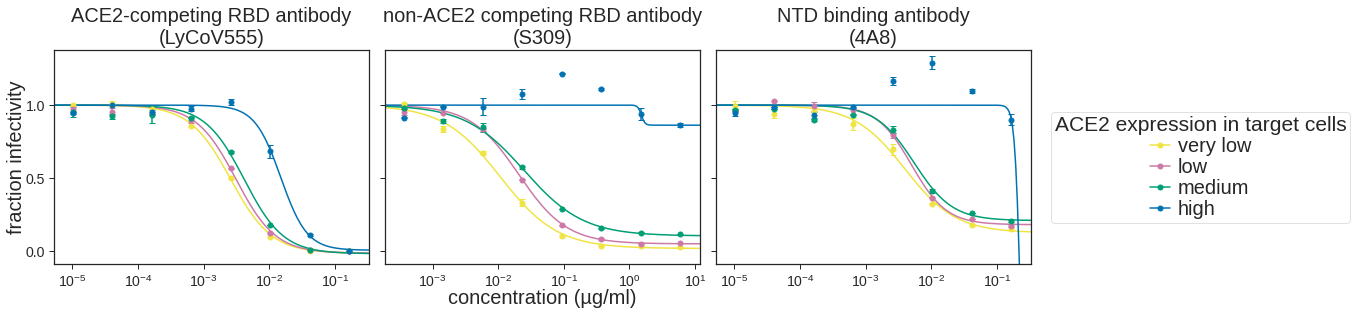

In [14]:
fig, axes = fits.plotSera(
                          viruses=['very low', 'low', 'medium', 'high'],
                          xlabel='concentration (µg/ml)',
                          ncol=3,
                          widthscale=1.5,
                          heightscale=1.5,
                          titlesize=20, labelsize=20, ticksize=14,
                          legendfontsize=20, yticklocs=[0,0.5,1],
                          markersize=5, linewidth=1.5,
                          legendtitle='ACE2 expression in target cells' ,
                          virus_to_color_marker={
                              'very low': ('#F0E442', 'o'),
                              'low': ('#CC79A7', 'o'),
                              'medium': ('#009E73', 'o'),
                              'high': ('#0072B2', 'o')},
                          sharex=False
                         )